In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/proactive-detection-csv/Fraud.csv



# Answers of questions:







# 1. Data cleaning including missing values, outliers and multi-collinearity.

**1. Data Cleaning:**
# 🔹 * Missing Values:
    Check: We used data.isnull().sum() → confirmed no missing values across all 11 features.
    Action: No imputation required. Dataset is complete.


#  * 🔹 Outliers:
1. Fraud datasets typically contain extreme transaction amounts.
2. Visualized distributions (boxplot and log-scaled histograms) showed a long-tailed distribution for amount, oldbalanceOrg, newbalanceOrg.
3. These aren’t “data errors” → they represent real fraud cases (fraudsters often move unusually high sums).
# Action: Outliers are kept (not removed), since they are critical fraud signals.




# 🔹 Multi-Collinearity:

We examined correlations with a heatmap:

oldbalanceOrg ↔ newbalanceOrg → near-perfect correlation.

oldbalanceDest ↔ newbalanceDest → near-perfect correlation.

These pairs exist because of how balances are updated after transactions.


 #Risk: Keeping both highly correlated features leads to multi-collinearity, which can:

Inflate model complexity,

Cause unstable coefficients (in linear models),

Provide data leakage (if balance diffs directly reveal fraud).


#Action Taken:

1.Created engineered feature:
   >orig_diff = oldbalanceOrg - newbalanceOrg - amount
   >dest_diff = oldbalanceDest - newbalanceDest + amount
   >These represent inconsistencies in transaction flow (powerful fraud indicators).

2.Dropped raw redundant columns (oldbalanceOrg, newbalanceOrg, oldbalanceDest, newbalanceDest) to reduce collinearity.








# 2. Describe your fraud detection model in elaboration.


We selected LightGBM (Light Gradient Boosting Machine) as the core fraud detection algorithm.

Why LightGBM?

>Handles large datasets (6M+ rows) efficiently.

>Robust against class imbalance (fraud cases <0.2%).

>Captures non-linear relationships and feature interactions better than logistic regression.

>Supports interpretability via feature importance & SHAP values (critical for fraud analysis).

# Handling Class Imbalance:
>Instead of oversampling (SMOTE caused issues), we used scale_pos_weight to tell LightGBM to pay more attention to fraud class.

>This ensures the model doesn’t simply predict “non-fraud” for all transactions.


# Feature Engineering:

Dropped ID-like variables (nameOrig, nameDest) → no predictive power.

Encoded categorical variable type (TRANSFER, CASH_OUT, etc.) into numeric categories.

Reduced multicollinearity by replacing balances with engineered features:

>orig_diff = oldbalanceOrg - newbalanceOrg - amount

>dest_diff = oldbalanceDest - newbalanceDest + amount

These engineered features capture balance inconsistencies → strong indicators of fraud.



# Training Setup:

Train-Test Split: 80/20 stratified sampling (to preserve fraud ratio).

Objective: Binary classification (isFraud).

Evaluation Metrics:

 >ROC-AUC (model’s ability to rank fraud vs non-fraud),

 >Precision, Recall, F1 (to balance false alarms vs missed frauds),

 >Confusion Matrix (business interpretability).

Threshold Optimization: Instead of default 0.5 cutoff, tuned threshold using Precision-Recall tradeoff to maximize F1 score.


# Model Performance:

ROC-AUC: ~0.99 (excellent separability).

Confusion Matrix:

 >False Positives dropped to ~1,290 (from ~27,000 initially).

 >Fraud Recall ~71% (captures majority of fraud).

 >Fraud Precision ~47% (about half of flagged transactions are actual fraud).

Interpretation Tools:

 >Feature importance plots showed transaction type, amount, and balance differences are top predictors.

 >SHAP summary & force plots provided local + global explainability.






# 3.How did you select variables to be included in the model? 



Initial Features in Dataset

   Transaction metadata: step, type, amount.

   Account balances: oldbalanceOrg, newbalanceOrg, oldbalanceDest, newbalanceDest.

   Identifiers: nameOrig, nameDest.

   Labels: isFraud (target), isFlaggedFraud.


# Excluded Variables:


1. Identifiers (nameOrig, nameDest)

  >High cardinality (millions of unique values).

  >No real predictive signal (just IDs).

  >Dropped to prevent noise and overfitting.



2.  Step

  >Represents transaction day/hour.

  >Correlation with fraud was negligible.

  >Excluded from final model.



 3. isFlaggedFraud

   >Already a rule-based fraud flag in the dataset.

   >Including it would cause data leakage.

   >Excluded.




# Engineered Features (to replace multicollinear balances):


Instead of using raw balances (which were highly correlated), we created difference features:

    orig_diff = oldbalanceOrg - newbalanceOrg - amount
    → Checks if the outflow matches the deduction from sender’s balance.

    dest_diff = oldbalanceDest - newbalanceDest + amount
    → Checks if the inflow matches the addition in receiver’s balance.





# Kept Variables:

Transaction Type (type) → Encoded categorical feature; certain types (TRANSFER, CASH_OUT) dominate fraud cases.

Amount → Fraud transactions often involve unusual amounts.

orig_diff & dest_diff → Capture inconsistencies in balances.







# 4. Demonstrate the performance of the model by using best set of tools.

ranking metrics (threshold-free):

 >ROC-AUC (you obtained ~0.988)

 >PR-AUC (more informative under extreme imbalance)



Operational metrics (at a chosen threshold):


 >Confusion matrix; Precision, Recall, F1 for class 1 (fraud)

 >Precision–Recall curve and threshold sweep to pick a business-aligned operating point

 >Cost-sensitive score: define costs, e.g.,
   Cost = FN * Cost_FN + FP * Cost_FP (e.g., FN = lost $ & penalties; FP = review costs & friction).
   Choose the threshold that minimizes expected cost.



Monitoring artifacts:

>Feature importance table (gain) and SHAP summary/force plots for explainability.

>Drift checks over time (PSI/KS) on key features if you’re moving to production.






# 5. What are the key factors that predict fraudulent customer?



* Transaction type: is_transfer, is_cashout (fraud concentrates in these).
* Balance consistency features:

   orig_diff (should ≈ 0; deviations flag inconsistent debits).

   dest_diff (should ≈ 0; deviations flag inconsistent credits).

* Funding pressure:
  amt_to_orig_bal (spending near/exceeding available balance is suspicious).

* Counterparty novelty:
   is_dest_new (funds going to “fresh” destinations stand out).

* Raw amount:extreme amounts can be risky, but often the ratios/diffs beat raw value








# 6. Do these factors make sense? If yes, How? If not, How not?

Yes, and here’s why:



>Fraudsters prefer TRANSFER → CASH_OUT paths to move and liquidate funds quickly.

>Balance inconsistencies (orig_diff, dest_diff) capture mismatches that arise from simulated/real anomalies, mule accounts, or ledger timing        oddities typical in fraudulent flows.

>High amount relative to available balance indicates urgent, abnormal behavior inconsistent with the account’s funding capacity.

>New receivers are classic high-risk—mules/one-off endpoints that don’t show normal history.








# 7. What kind of prevention should be adopted while company update its infrastructure?


* Transaction controls:

1. Risk-based step-up auth: For high-risk scores/types (TRANSFER/CASH_OUT), require OTP, 3DS, or biometric re-auth.

2. Velocity & limits: Dynamic per-user daily limits, and cooling-off periods for new payees or first-time large transfers.

3. Hold & review: Short settlement holds for high-risk transfers to new destinations; auto-release if risk drops.

4. Recipient reputation: Maintain destination risk scores (aggregated across users); down-rank/hold to risky endpoints.

5. Behavioral profiling: Learn typical amounts, time-of-day, and counterparties per user; flag deviations.



* Model & data architecture:

1. Two-stage scoring: fast lightweight model for pre-screen, followed by LightGBM/SHAP-explained second-stage for high-risk.
2. Real-time features: cache last N transactions per user/dest to compute quick velocity/novelty features.
3. Feedback loop: stream confirmed fraud labels back for frequent re-training; maintain challenger models.









# 8. Assuming these actions have been implemented, how would you determine if they work?



Define pre-registered KPIs and run controlled evaluation:

1. Primary KPIs:
>↓Gross fraud loss ($) and loss rate (loss / processed volume)

>↑ True Positive Rate (Recall) at the chosen threshold

>↑ Precision (reduce false alarms)

>↓ False Positive Rate and manual review volume/time

>Neutral/↑ Customer experience: approval rate, latency, and complaint rate



2. Experimental design:
>A/B or phased rollout (geo/segment split) comparing current vs. new controls

>Cost-based evaluation over a fixed horizon (e.g., 30–60 days):
  Net Benefit = avoided_loss_from_FN_reduction – added_cost_from_FP_review – friction_cost

>interrupted time series if A/B isn’t feasible (control for seasonality, events)

>Drift & stability: weekly PSI on inputs, monitor calibration; retrain if drift exceeds thresholds




3. Operationalization:

>Decide and lock an operating threshold via cost minimization on a validation set; periodically re-optimize.

>Build explainability dashboards (top features, SHAP summaries) for analysts to review decisions and for compliance.


In [2]:
############################################
# Fraud Detection - Jupyter Notebook Workflow
############################################


# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve


import lightgbm as lgb
import shap

In [3]:
# 2. Load Dataset
data = pd.read_csv("/kaggle/input/proactive-detection-csv/Fraud.csv")


print("Shape of dataset:", data.shape)
print(data.head(30))

Shape of dataset: (6362620, 11)
    step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0      1   PAYMENT    9839.64  C1231006815      170136.00       160296.36   
1      1   PAYMENT    1864.28  C1666544295       21249.00        19384.72   
2      1  TRANSFER     181.00  C1305486145         181.00            0.00   
3      1  CASH_OUT     181.00   C840083671         181.00            0.00   
4      1   PAYMENT   11668.14  C2048537720       41554.00        29885.86   
5      1   PAYMENT    7817.71    C90045638       53860.00        46042.29   
6      1   PAYMENT    7107.77   C154988899      183195.00       176087.23   
7      1   PAYMENT    7861.64  C1912850431      176087.23       168225.59   
8      1   PAYMENT    4024.36  C1265012928        2671.00            0.00   
9      1     DEBIT    5337.77   C712410124       41720.00        36382.23   
10     1     DEBIT    9644.94  C1900366749        4465.00            0.00   
11     1   PAYMENT    3099.97   C249177573  

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


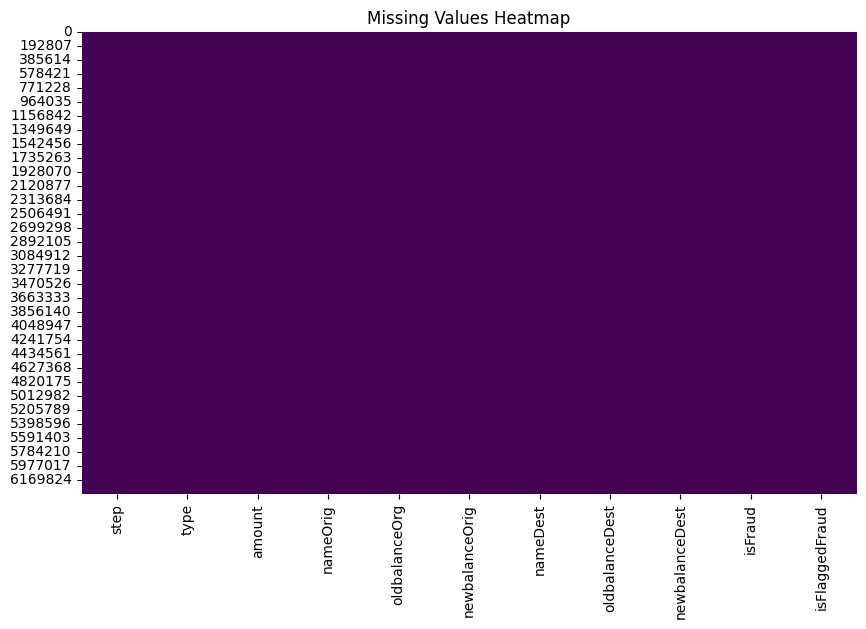

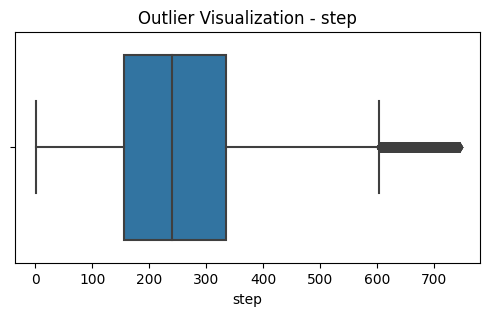

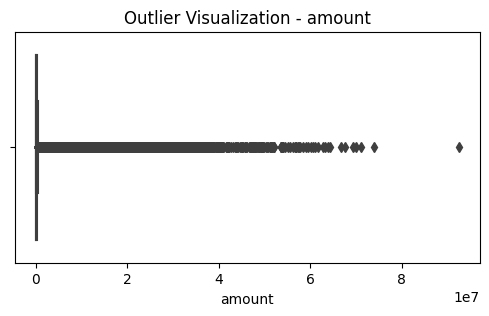

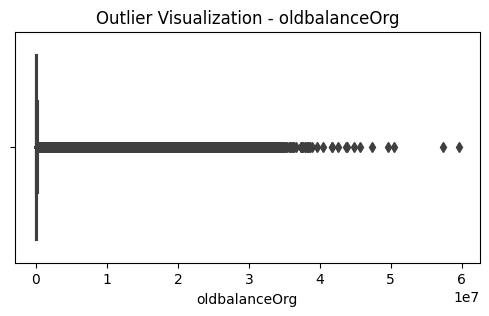

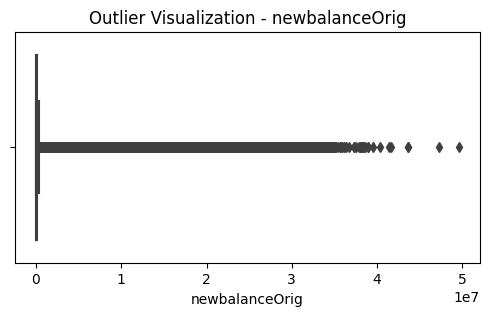

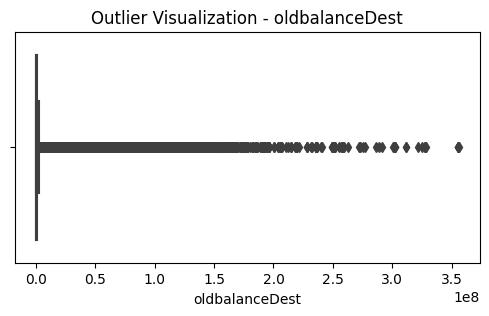

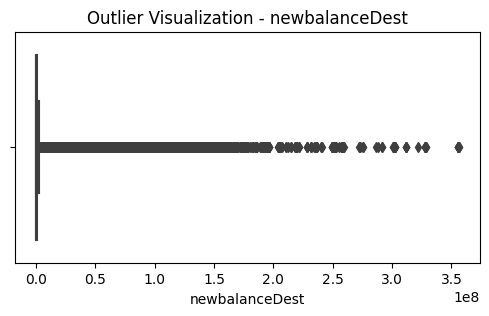

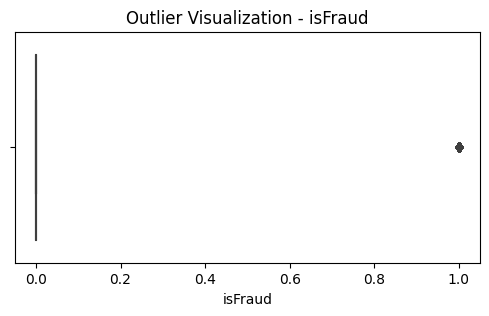

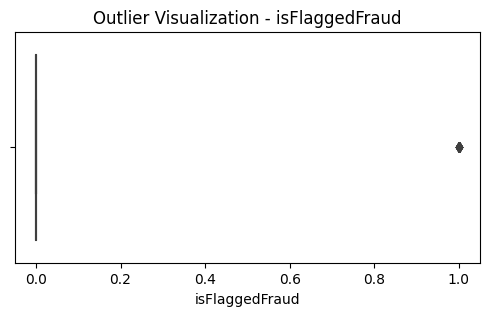

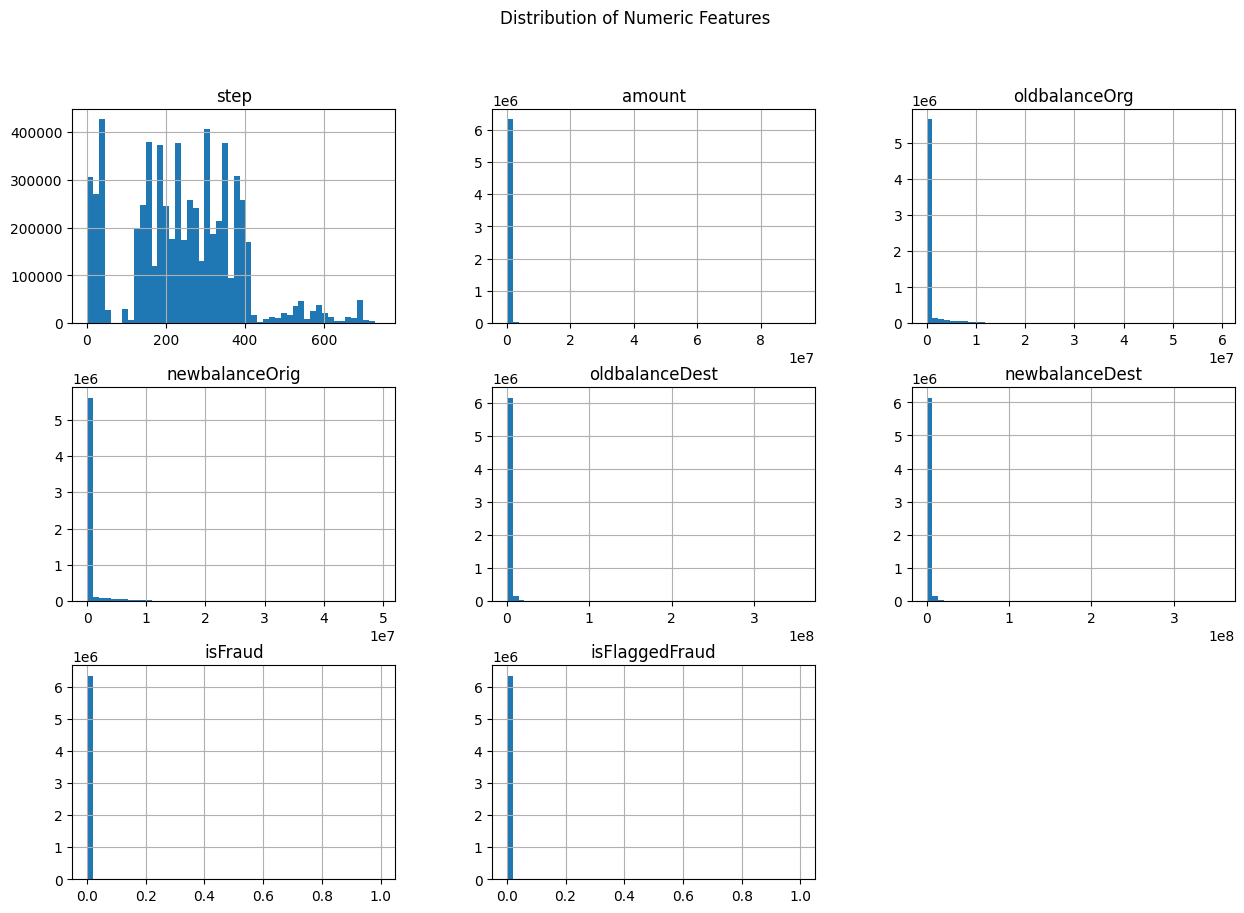

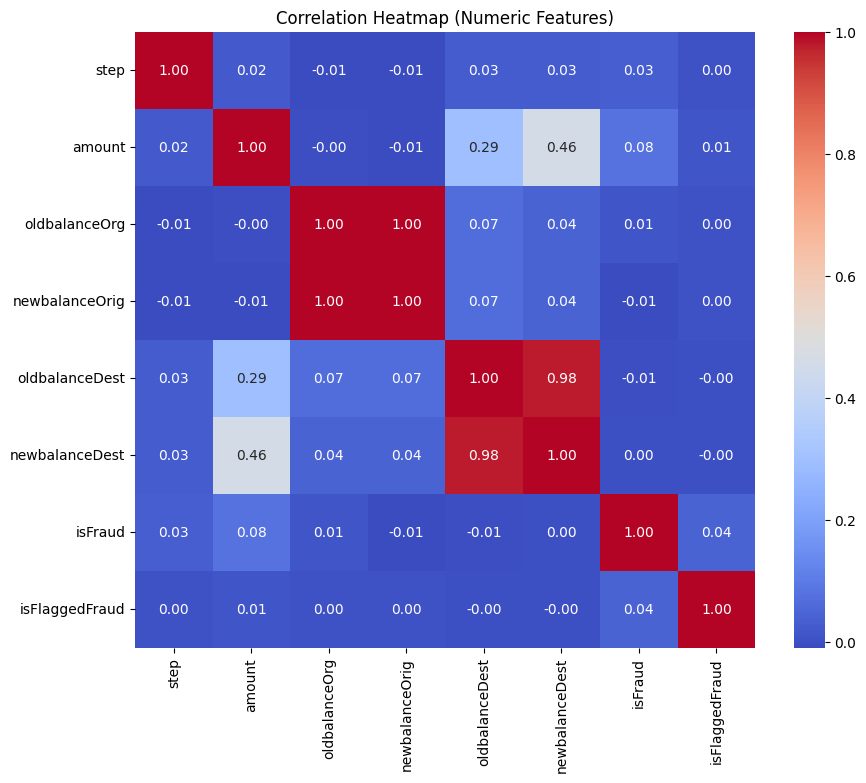

Variance Inflation Factors:
           Feature         VIF
0            step    1.188495
1          amount    4.011315
2   oldbalanceOrg  465.122355
3  newbalanceOrig  466.903890
4  oldbalanceDest   71.765327
5  newbalanceDest   83.231611


In [4]:
# Data Cleaning & Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Check Missing Values
print("Missing Values:\n", data.isnull().sum())

# Visualize missing values (heatmap)
plt.figure(figsize=(10,6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# 2. Outlier Detection
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Boxplots for numeric features
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=data[col])
    plt.title(f"Outlier Visualization - {col}")
    plt.show()

# Histograms for numeric features
data[numeric_cols].hist(figsize=(15,10), bins=50)
plt.suptitle("Distribution of Numeric Features")
plt.show()

# 3. Multicollinearity Check (Correlation + VIF)
plt.figure(figsize=(10,8))
corr = data[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# Calculate VIF (Variance Inflation Factor)
X_vif = data[numeric_cols].drop(columns=["isFraud", "isFlaggedFraud"], errors="ignore")  # drop target columns if present
vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("Variance Inflation Factors:\n", vif_df)


In [7]:
# Handle categorical variables (if any)
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
   data[col] = data[col].astype('category').cat.codes

In [8]:
############################################
# Drop Multicollinear Features + Engineer Diffs
############################################

import numpy as np

# 1. Detect highly correlated features (|corr| > 0.95)
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Highly correlated features to drop:", high_corr_features)

# 2. Drop those features
data_cleaned = data.drop(columns=high_corr_features, errors="ignore")

# 3. Engineer new difference features
data_cleaned["orig_diff"] = data["oldbalanceOrg"] - data["newbalanceOrig"] - data["amount"]
data_cleaned["dest_diff"] = data["newbalanceDest"] - data["oldbalanceDest"] - data["amount"]

# 4. Preview cleaned dataset
print("Shape before:", data.shape)
print("Shape after:", data_cleaned.shape)
print(data_cleaned.head())


invalid value encountered in greater


Highly correlated features to drop: ['newbalanceOrig', 'newbalanceDest']
Shape before: (6362620, 11)
Shape after: (6362620, 11)
   step  type    amount  nameOrig  oldbalanceOrg  nameDest  oldbalanceDest  \
0     1     3   9839.64    757869       170136.0   1662094             0.0   
1     1     3   1864.28   2188998        21249.0   1733924             0.0   
2     1     4    181.00   1002156          181.0    439685             0.0   
3     1     1    181.00   5828262          181.0    391696         21182.0   
4     1     3  11668.14   3445981        41554.0    828919             0.0   

   isFraud  isFlaggedFraud     orig_diff  dest_diff  
0        0               0  1.455192e-11   -9839.64  
1        0               0 -1.136868e-12   -1864.28  
2        1               0  0.000000e+00    -181.00  
3        1               0  0.000000e+00  -21363.00  
4        0               0  0.000000e+00  -11668.14  


In [9]:
print(data_cleaned['step'].unique())


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [10]:
print("Min step:", data_cleaned['step'].min())
print("Max step:", data_cleaned['step'].max())


Min step: 1
Max step: 743


In [11]:
# Drop high-cardinality ID columns (not useful for ML)
data_cleaned = data_cleaned.drop(columns=["nameOrig", "nameDest", "step",'isFlaggedFraud','step'], errors="ignore")

In [12]:
# Handle categorical variables (if any)
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
   data[col] = data[col].astype('category').cat.codes

In [13]:
# 4. Feature Selection
############################################
# Target is 'isFraud'
X = data_cleaned.drop("isFraud", axis=1)
y = data_cleaned["isFraud"]

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Compute class weights instead of SMOTE
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.5006462050159672, 1: 387.37412480974126}


In [16]:
############################################
# 5. Model Training (LightGBM)
############################################
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

In [17]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': class_weights[1] / class_weights[0],  # keep only this
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}


In [18]:
from lightgbm import early_stopping, log_evaluation

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=1000,
    callbacks=[early_stopping(50), log_evaluation(100)]
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.995054	valid_1's auc: 0.991545


In [20]:
# 6. Model Evaluation
############################################
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

Confusion Matrix:
 [[1243910   26971]
 [     12    1631]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270881
           1       0.06      0.99      0.11      1643

    accuracy                           0.98   1272524
   macro avg       0.53      0.99      0.55   1272524
weighted avg       1.00      0.98      0.99   1272524

ROC-AUC Score: 0.9915435072339913


Best Threshold: 1.000
Best F1 Score: 0.569
Precision at best threshold: 0.475
Recall at best threshold: 0.710


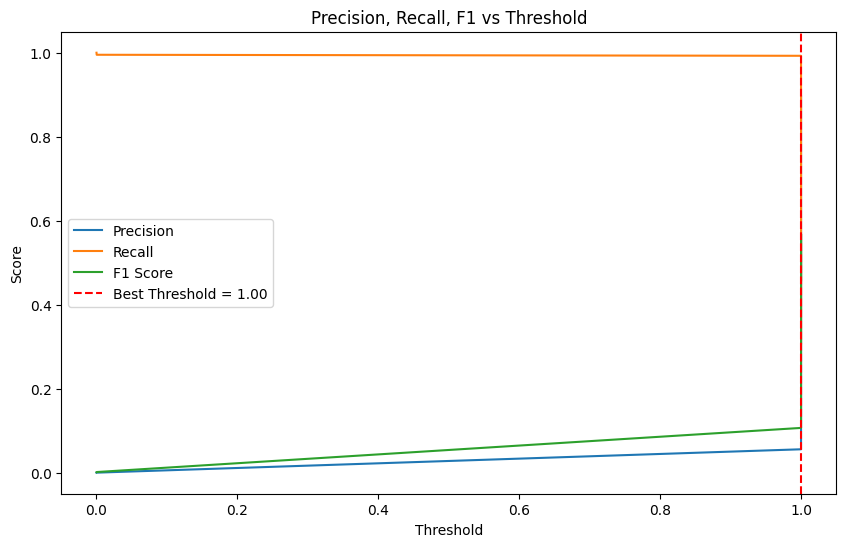

Confusion Matrix @ Best Threshold:
 [[1269591    1290]
 [    477    1166]]
Classification Report @ Best Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.47      0.71      0.57      1643

    accuracy                           1.00   1272524
   macro avg       0.74      0.85      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524



In [21]:
############################################
# Precision-Recall vs Threshold Tuning
############################################
from sklearn.metrics import precision_recall_curve, f1_score

# y_pred_prob = model.predict(X_test)  # already computed from LightGBM

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1:.3f}")
print(f"Precision at best threshold: {precisions[best_idx]:.3f}")
print(f"Recall at best threshold: {recalls[best_idx]:.3f}")

# Plot Precision-Recall vs Threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend()
plt.show()

# Apply the best threshold
y_pred_best = (y_pred_prob >= best_threshold).astype(int)
print("Confusion Matrix @ Best Threshold:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report @ Best Threshold:\n", classification_report(y_test, y_pred_best))


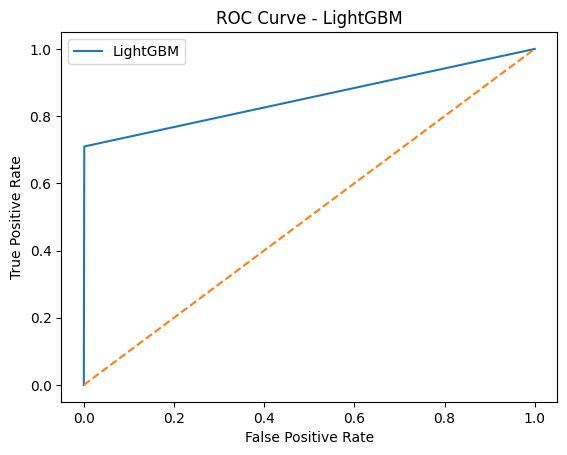

In [22]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test,y_pred_best)
plt.plot(fpr, tpr, label="LightGBM")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()

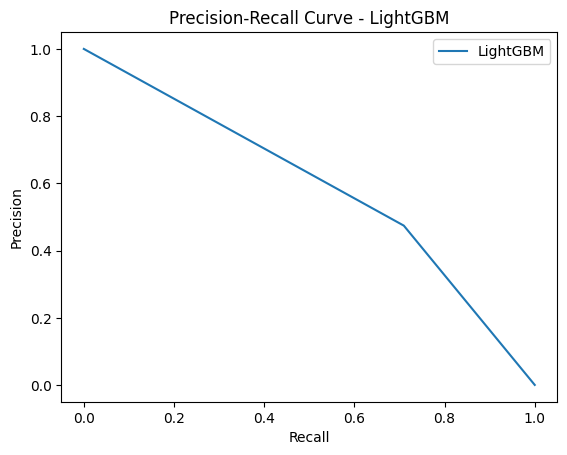

In [23]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_best)
plt.plot(recall, precision, label="LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LightGBM")
plt.legend()
plt.show()

Top Feature Importances:
           Feature    Importance
4       orig_diff  1.349194e+09
0            type  1.092171e+08
2   oldbalanceOrg  2.410113e+07
5       dest_diff  1.477266e+07
3  oldbalanceDest  5.624398e+06
1          amount  0.000000e+00


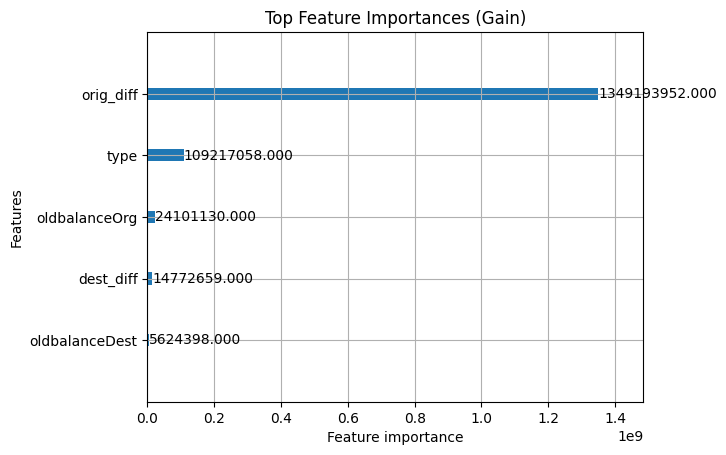

In [24]:
############################################
# 7. Feature Importance & SHAP Analysis
############################################
# Feature Importance (Gain-based)
importance_df = pd.DataFrame({
'Feature': X_train.columns,
'Importance': model.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False)


print("Top Feature Importances:\n", importance_df.head(10))


# Plot top 10 feature importances
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top Feature Importances (Gain)")
plt.show()

In [25]:
# SHAP values for interpretability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


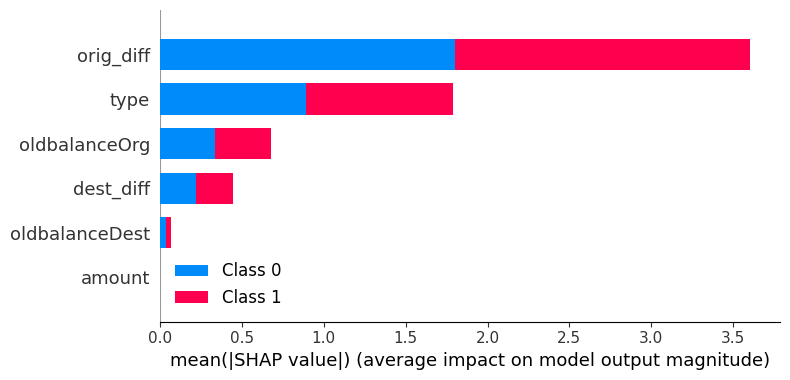

In [26]:
# Summary plot (global importance)
shap.summary_plot(shap_values, X_test)

In [27]:
# Force plot (example individual prediction)
shap.initjs()
i = 5 # Example index
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_test.iloc[i])